Solve et coagula!

Evaluate the crossling method: represent STs and TTs (of my parallel prof corpus) with fvectors, AfPr-cluster on their square matrices of pair-wise sims, find most similar and calculate ARI for STs as gold classes and TTs as predictions

get N most similar from the 2.6M RNC and 17M newspaper corpora on NN functional vectors

In [1]:
import sys
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn import metrics

import pandas as pd
from operator import itemgetter

from sklearn.metrics import confusion_matrix
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

## to avoid reloading kernel after changes to imported modules
import importlib

import helper as mm
importlib.reload(mm)

# my functions
from helper import my_open

import warnings; warnings.simplefilter('ignore')

# Apply round off setting to whole notebook
np.set_printoptions(precision=3)

In [2]:
## =MIXED REPS=
## to evaluate the crosslinguistic compatibility of functional vectors produced by 
en_pro = my_open('/home/masha/venv/genre-keras/paper_code/data/enbiLSTMa_rltcpro_mixed.res')
ru_pro = my_open('/home/masha/venv/genre-keras/paper_code/data/rubiLSTM_ru_pro517_mixed.res')
en_pro.name = 'en_sources'
ru_pro.name = 'ru_targets_pro'
print(en_pro.head())
print(ru_pro.head())

          argumentA1  fictionA4  instructionA7    newsA8   legalA9  \
filename                                                             
en_1        0.289104   0.003830       0.023028  0.080273  0.002813   
en_10       0.042703   0.025112       0.072509  0.018917  0.001951   
en_100      0.199965   0.004515       0.050283  0.113799  0.005423   
en_101      0.064116   0.006307       0.084049  0.006232  0.005449   
en_102      0.042813   0.006283       0.101651  0.004373  0.003963   

          personalA11  promotionA12  scitechA14   infoA16   evalA17  
filename                                                             
en_1         0.038077      0.033491    0.183838  0.150705  0.009491  
en_10        0.045962      0.038756    0.008025  0.049200  0.019896  
en_100       0.068925      0.050354    0.126648  0.159246  0.035249  
en_101       0.037097      0.733266    0.010217  0.007695  0.043606  
en_102       0.047350      0.556811    0.003919  0.017140  0.032568  
          argumentA

In [3]:
def get_meanFTDs(df):
    dfm = df.copy()
    dfm.loc['Mean',:] = df.mean(axis=0)
    res = dfm.loc['Mean', :]
    print('Average values on FTDs for %s' % df.name)
    return res
print(get_meanFTDs(en_pro))
print(get_meanFTDs(ru_pro))

Average values on FTDs for en_sources
argumentA1       0.260579
fictionA4        0.031694
instructionA7    0.072677
newsA8           0.108011
legalA9          0.005896
personalA11      0.057641
promotionA12     0.102653
scitechA14       0.051428
infoA16          0.091950
evalA17          0.042545
Name: Mean, dtype: float64
Average values on FTDs for ru_targets_pro
argumentA1       0.473993
fictionA4        0.027434
instructionA7    0.042927
newsA8           0.196760
legalA9          0.008747
personalA11      0.137064
promotionA12     0.036238
scitechA14       0.124269
infoA16          0.125905
evalA17          0.060551
Name: Mean, dtype: float64


clustering on monocorpus similarity matrices and comparing centers

In [4]:
from helper import calc_sim
# measure internal corpus similarity: get a square matrix of pairwise sims for each corpus
# calculate similarity of croco and rltc texts to themselves = homogeneity

simmat_en, mean_en = calc_sim('euclidean', en_pro, en_pro, 'NN')
print(simmat_en.shape)
print('Homogeneity EN_ST:',mean_en)
simmat_ru, mean_ru = calc_sim('euclidean', ru_pro, ru_pro, 'NN')
print(simmat_ru.shape)
print('Homogeneity RU_TT:',mean_ru)

(517, 517)
Homogeneity EN_ST: 0.5013317291192977
(517, 517)
Homogeneity RU_TT: 0.3506090424571902


In [5]:
from helper import clustering_matrix
# apply affinity to the square matrices

labels_en, clustered_en, centers_en = clustering_matrix('affinity', simmat_en, en_pro.index.tolist(), 
                                     'pca', 'mono en_pro', 0.9, -5, plotting=0)
print(clustered_en[['size', 'center']]) # ,'files'

labels_ru, clustered_ru, centers_ru = clustering_matrix('affinity', simmat_ru, ru_pro.index.tolist(), 
                                     'pca', 'mono ru_pro', 0.9, -10, plotting=0)
print(clustered_ru[['size', 'center']])

Converged after 48 iterations.
         size      center
cluster                  
3         237  en_5ps4_57
0         157      en_133
1          66       en_37
2          57      en_384


Estimated number of clusters: 4


Converged after 46 iterations.
         size  center
cluster              
2         192  ru_530
3         166  ru_551
0          95  ru_202
1          64  ru_251


Estimated number of clusters: 4


I have the code to calculate pair-wize similarity of cluster centers that applies to KMEANS rather than affinity, sooo I am switchin to KMEANS naturally I want the same number of clusters in ST and TT and AP did not oblige!!!

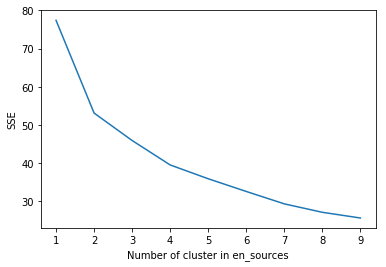

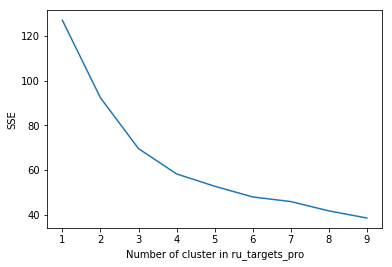

In [6]:
# calculate k for k means
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.spatial import distance

# the method is based on the principle of Diminishing Returns
# it produces a Scree Plot, a simple line segment plot 
def must_see_k(df):
    sse = {}
        # try this for all X
    for k in range(1, 10):
        kmeans = KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=3000,
        n_clusters=k, n_init=2, n_jobs=1, precompute_distances='auto',
        random_state=50, tol=0.0001, verbose=0).fit(df.as_matrix())

#         df["clusters"] = kmeans.labels_
        #print(data["clusters"])
        sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster in %s" % df.name)
    plt.ylabel("SSE")
    plt.show()

must_see_k(en_pro)
must_see_k(ru_pro)

In [7]:
#KMeans cluster centers are not the points from the dataset!!! Find the closest actual text or use K-mediods
#https://stackoverflow.com/questions/42583995/get-the-centroid-row-index-from-k-means-clustering-using-sklearn
from scipy.spatial.distance import cdist
# df should have index set to filenames col
def kmeans_closest(df, k):
    model= KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=3000,
            n_clusters=k, n_init=2, n_jobs=1, precompute_distances='auto',
            random_state=50, tol=0.0001, verbose=0)
    # X is a df
    clusassign = model.fit_predict(df.as_matrix())
#     print('============',len(clusassign))
    min_dist = np.min(cdist(df.as_matrix(), model.cluster_centers_, 'euclidean'), axis=1)
    Y = pd.DataFrame(min_dist, index=df.index, columns=['Center_euclidean_dist'])
    Z = pd.DataFrame(clusassign, index=df.index, columns=['cluster'])
    PAP = pd.concat([Y,Z], axis=1)
    grouped = PAP.groupby(['cluster']) # I don't unsderstand why do this?
    centers_df = grouped.idxmin()

    closest_fns = centers_df['Center_euclidean_dist'].tolist()
    centers_df['size'] = PAP.reset_index().groupby('cluster')['filename'].count()
    fn_series = PAP.reset_index().groupby('cluster')['filename'].apply(list)
    centers_df.insert(2, 'files', fn_series)
    centers_df.columns = ['center', 'size', 'files']
#     print(centers_df)
    return closest_fns, centers_df, clusassign

from helper import get_twins, calc_sim
def get_similar_clusters(df1, k1, df2, k2):
    # returns list of fns for files closest to the calculated centriods, cluster-center-size-files df
    centers1, cldf1, preds1 = kmeans_closest(df1, k1)
#     print('===',cldf1.head(10))
      # this returns a df of all corpus2 clusters
    centers2, cldf2, preds2 = kmeans_closest(df2, k2)
    # print(rltc_centers)

    # # get and compare centers vectors
    centers1_1 = df1.loc[centers1]
    centers1_1.name = 'corpus1'
    
    centers2_2 = df2.loc[centers2]
    centers2_2.name = 'corpus2'
#     print(centers1_1, centers2_2)
    simmat_centers, av_pair_sims = calc_sim('euclidean', centers1_1, centers2_2, 'NN')
#     print('===', simmat_centers, av_pair_sims)
    
    matched, sim_scores = get_twins(simmat_centers, 'euclidean', centers1_1, centers2_2, 'NN')
    print(sim_scores)

    matched_centers = matched['corpus2'].tolist()
#     print(matched_centers)
    get_em = pd.DataFrame()
    for i in matched_centers:
        similar = cldf2[cldf2['center']==i]
        get_em = get_em.append(similar)
        get_em = get_em.sort_values('center')
    
    similar_size = get_em['size'].tolist()

    matched.insert(1, 'size1', cldf1['size'])
    matched.insert(2, 'max_similarity', sim_scores)
#     print('FIRST', matched)
### spent the whole day trying to figure out WHY the similarity score are so volatile!!! because of this sorting which is done Before the list of sims is added!!
### NO sorting messes up with the size of the matched clusters!
    matched = matched.sort_values('corpus2')
#     print('SECOND', matched)
#     print(len(matched), len(similar_size))
    matched.insert(4, 'size2', similar_size)
    
    return cldf1, get_em, matched, preds1, preds2

### returns: 
# (1) cluster-center-size-files df for corpus1, 
# (2) cluster-center-size-files df for only matched clusters from df 2, 
# (3) summury df, including sim val between the clusters_centroids found most similar 
# (4-5) labels for clusters: 1 0 1 1 2 0 3 ...
en_clusters, matched_ru, ataglance, y_kmeans1, y_kmeans2 = get_similar_clusters(en_pro, 4, ru_pro, 4)

print('Clusters of enST against clusteres of their ruTT')
print(ataglance)
print(y_kmeans1[:10])

The range of similarity values among most similar in NN output (euclidean): 0.567 0.8212458162895201
====== [0.723 0.821 0.567 0.695]
en_133	ru_530
en_5ps4_57	ru_551
en_440	ru_551
en_42	ru_202
Number of unique most similar texts from rltc: 3
[0.723 0.821 0.567 0.695]
Clusters of enST against clusteres of their ruTT
      corpus1  size1  max_similarity corpus2  size2
3       en_42     56        0.694963  ru_202     85
0      en_133    143        0.723439  ru_530    193
1  en_5ps4_57    266        0.821246  ru_551    186
2      en_440     52        0.567198  ru_551    186
[1 1 1 2 2 2 2 1 2 1]


In [8]:
# for each cluster get average vals for each FTD and std
import operator
from collections import OrderedDict

def freqdict_from_list(my_list):
    freqd = {}
    for i in set(my_list):
        freq = my_list.count(i)
        if i in freqd:
            freqd[i] += freq
        else:
            freqd[i] = freq
    # order and sort the freqdict to get a list of tuples
    my_sorted_tuples = OrderedDict(sorted(freqd.items(), key=operator.itemgetter(1), reverse=True))
    return my_sorted_tuples
# expects: cluster-center-size-files df for corpus (=clusters) and original df
def get_clusters_average(clusters, orig):
    clusters0 = clusters.copy()
    homogens = {}
    
    new_dict = {}
    files = {}
    genres = {}
    done = []
#     print(clusters)
    ### it is hopeless with the duplicates!
    clusters0['files'] = clusters0['files'].apply(', '.join)
    clusters0 = clusters0.reset_index().drop_duplicates().set_index(['cluster'])
    ## Finallyyyy
#     print(clusters.shape)
    clusters0['files'] = clusters0['files'].str.split(', ')
#     print(clusters)
    matches = clusters0['center'].tolist() # deal with duplicates
#     print(clusters['center'].tolist())
#     print(len(matches))
    for i in matches:
        print(i)
        #     print(cro_clusters[cro_clusters['center'] == i]['files'])
        fns = clusters0[clusters0['center'] == i]['files'].tolist()
        print('===', fns)
        fns = [y.strip() for x in fns for y in x]  # flatten the list
        this_slice = orig.loc[fns]
        print(len(this_slice))
        this_slice.loc['Average',:] = this_slice.mean(axis=0).round(2)
        _, homogen = calc_sim('euclidean', this_slice, this_slice, 'NN')
        homogens[i] = homogen
        files[i] = fns
        collect_labs = []
        for f in fns:
            genrelab = f.split('_')[1]
            collect_labs.append(genrelab)
        genre_tuples = freqdict_from_list(collect_labs)
        genres[i] = genre_tuples   
        avvals = this_slice.loc['Average'].tolist()
        functions = this_slice.columns.tolist()
        tups = zip(functions, avvals)
        my_dict = {}
        for k,v in tups:
            k = k[:-3]
            my_dict[k] = v
#             print(k,v)
            # sort the dict on vals to get a list of tuples
        sorted_d = sorted(my_dict.items(), key=operator.itemgetter(1), reverse=True)
    #     print(sorted_d)
        new_dict[i] = sorted_d[:3]
    #     print(fns)
    print(new_dict)
# returns 
# (1) a dict with cluster nums as keys and 10-key dicts for avvals for FTD as values 
# (2) a dict with homogeneity score for each cluster     
# (3) if your fns were genre-labled (this applies for bnc only! otherwise returns rubbish)
# (4) a dict with list of fns for each cluster
    return new_dict, homogens, genres, files

# this is how the function is called on the results of KMeans clustering
en_dict, en_homo, en_genres, en_files = get_clusters_average(en_clusters, en_pro)
ru_dict, ru_homo, ru_genres, ru_files = get_clusters_average(matched_ru, ru_pro)

## this was suppiosed to work in conjunction with functions that apply KMean to the corpora
ataglance.insert(2, 'average_FTD1', ataglance['corpus1'].map(en_dict))
ataglance.insert(5, 'average_FTD2', ataglance['corpus2'].map(ru_dict))
ataglance.insert(3, 'homogen1', ataglance['corpus1'].map(en_homo))
ataglance.insert(6, 'homogen2', ataglance['corpus2'].map(ru_homo))

print(ataglance)

en_133
=== [['en_10ps1_123', 'en_10ps3_125', 'en_111', 'en_112', 'en_113', 'en_114', 'en_115', 'en_11ps2_131', 'en_11ps3_132', 'en_11ps5_134', 'en_11ps6_135', 'en_11ps7_136', 'en_124', 'en_126', 'en_128', 'en_130', 'en_131', 'en_133', 'en_134', 'en_135', 'en_137', 'en_138', 'en_139', 'en_140', 'en_142', 'en_145', 'en_147', 'en_148', 'en_153', 'en_154', 'en_155', 'en_157', 'en_158', 'en_159', 'en_16', 'en_161', 'en_162', 'en_164', 'en_165', 'en_167', 'en_168', 'en_17', 'en_170', 'en_174', 'en_177', 'en_179', 'en_183', 'en_185', 'en_187', 'en_188', 'en_189', 'en_19', 'en_190', 'en_191', 'en_194', 'en_196', 'en_197', 'en_1ps1_1', 'en_1ps3_3', 'en_1ps4_4', 'en_1ps6_6', 'en_1ps8_8', 'en_1ps9_9', 'en_200', 'en_202', 'en_204', 'en_227', 'en_23', 'en_232', 'en_237', 'en_241', 'en_247', 'en_250', 'en_288', 'en_29', 'en_296', 'en_32', 'en_321', 'en_347', 'en_39', 'en_3ps1_31', 'en_3ps3_33', 'en_3ps4_34', 'en_3ps5_35', 'en_3ps7_37', 'en_4', 'en_41', 'en_43', 'en_439', 'en_44', 'en_443', 'en_444',

In [9]:
from sklearn.metrics.cluster import adjusted_rand_score

# give the metrics the lists (same order of instances is a MUST!): 
# (1) a list of names for true classes and 
# (2) a list of predicted cluster numbers from KMeans, for example

# in this implementation my classes are clusters numbers for sources and the predictions are clusteres of targets
# make sure they are in the same order!!
print(adjusted_rand_score(y_kmeans1, y_kmeans2))

0.10577580936779249


Clearly this idea to evaluate the possibility for direct application of two models learnt on EN and RU annotated trainsets did not work out

the idea was to cluster sources and targets on vectors predicted by monolang model and expect to find them neatly clustered against each other

Lets try to measure avarage similarity between sources and targets  compared to av sim to other texts? 
In the joint matrix en_pro, ru_pro there should be a clear diagonal of higher values between ST and TT!!! 

get a diagonal heatmap for first dozen filepairs

In [10]:
simmat_enVSru, mean_ = calc_sim('euclidean', en_pro, ru_pro, 'NN')
print(simmat_enVSru.shape) # it is an array, turn it to a df
df = pd.DataFrame(simmat_enVSru)
df.index = en_pro.index
df.columns = ru_pro.index
df_slice = df.iloc[:10, :10]
df_slice

(517, 517)


filename,ru_1,ru_10,ru_100,ru_101,ru_102,ru_103,ru_104,ru_105,ru_108,ru_109
filename,,,,,,,,,,
en_1,0.450459,0.771172,0.715559,0.683634,0.440518,-0.060639,0.668223,0.215980,0.403219,0.297023
en_10,0.227062,0.864188,0.755038,0.548930,0.283929,-0.174387,0.514491,-0.052196,0.340002,0.128344
en_100,0.419458,0.842715,0.788997,0.683766,0.422610,-0.077655,0.654195,0.144929,0.403744,0.257448
en_101,-0.075963,0.280941,0.231596,0.214178,-0.012553,-0.321195,0.153359,-0.284965,0.313954,0.065188
en_102,0.027821,0.448987,0.390953,0.340699,0.096177,-0.248959,0.279875,-0.202546,0.390670,0.121078
en_103,-0.066257,0.320662,0.262432,0.229776,0.035270,-0.096230,0.156559,-0.254276,0.456128,0.025158
en_104,0.071875,0.555879,0.494649,0.396444,0.134497,-0.242849,0.347351,-0.160648,0.389788,0.121346
en_105,0.338317,0.428314,0.389112,0.390062,0.181171,-0.289374,0.254990,0.385880,0.209532,0.059397
en_108,-0.094711,0.271619,0.212680,0.194542,-0.006070,-0.130182,0.118829,-0.280702,0.459742,0.022573


In [11]:
print(mean_)

0.3675904774932453


Average similarity for the ST-TT pairs: 0.5210086365570756
Alliluyay! it is higher that for translationally-unrelated textpairs, But not through the roof obviously!


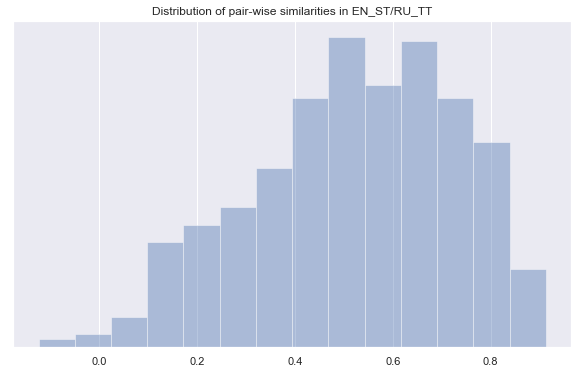

In [12]:
import math
## maybe I am not thinking straight and expect smth that i should not
## here comes the average not for ALL pairs in the enST and ruTT corpora (517X517) but for just all 517 pairs:
# print(en_pro.head())
# print(ru_pro.head())
st_tt_pairs = zip(en_pro.values, ru_pro.values)
sim_vals = []
for s,t in st_tt_pairs:
    euc_distance = 1 - math.sqrt(sum([(a - b) ** 2 for a, b in zip(s, t)]))
    sim_vals.append(euc_distance)
mean4pairs0 = np.average(sim_vals)
print('Average similarity for the ST-TT pairs:',mean4pairs0)
print('Alliluyay! it is higher that for translationally-unrelated textpairs, But not through the roof obviously!')
sns.set(rc={'figure.figsize':(10,6)})
g = sns.distplot(sim_vals, rug=False, hist=True, kde=False)
g.set_title('Distribution of pair-wise similarities in EN_ST/RU_TT')
g.yaxis.set_ticks([])
plt.show()

266772
Average similarity for the all other EN-RU pairs: 0.36729315547955577


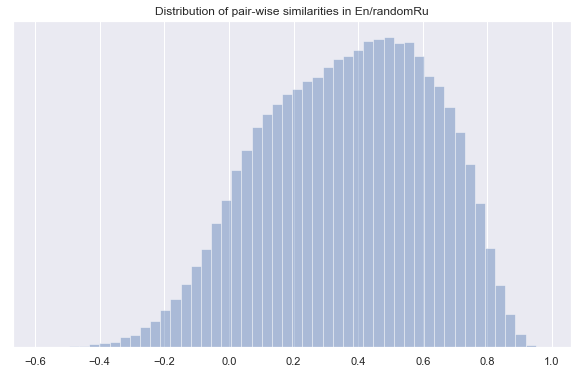

In [13]:
# get average sim for all combinations with other translations except own
other_pairs = []
for i in range(len(en_pro)):
    svect = en_pro.iloc[i, :].values
    for ii in range(len(ru_pro)):
        if ii != i:
            tvect = ru_pro.iloc[ii, :].values
            other_pairs.append((svect, tvect))
print(len(other_pairs))

sim_vals1 = []
for s,t in other_pairs:
    euc_distance = 1 - math.sqrt(sum([(a - b) ** 2 for a, b in zip(s, t)]))
    sim_vals1.append(euc_distance)
mean4pairs = np.average(sim_vals1)
print('Average similarity for the all other EN-RU pairs:',mean4pairs)
sns.set(rc={'figure.figsize':(10,6)})
g = sns.distplot(sim_vals1, rug=False, hist=True, kde=False)
g.set_title('Distribution of pair-wise similarities in En/randomRu')
g.yaxis.set_ticks([])
plt.show()

Observation: 

vectors produced for ST and TT by EN and RU models are not similar!

Discussion: 

The frustrastin gobservation: either the translations in my corpus are not functionally adequate

or

the models tained on russian and english train capture different properties under the same FTDs

can the failure to get high euclidean similarity scores for ST and their TT vectors be due to their incompatibility in terms of magnitude?

what if we compare them using our evaluation method based on binaried representations?

To do that treat ST vectors as golden (transsform ann2gold) and TT as preds

In [14]:
# this is a higher level function: it expects .ann and .pred and does ALL the converting on the fly
from evaluate import eval_NN
evaltype='macro' # binary, micro, weighted
mapping = {'A1': 'argument', 'A4': 'fiction', 'A7': 'instruction', 'A8': 'news', 
           'A9':'legal', 'A11': 'personal', 'A12': 'promotion', 
           'A14': 'scitech', 'A16': 'info', 'A17': 'eval'}
# in the current setting to compare predictions for ST and for TT with two models based on binarized  vectors 
# we treat predictions for en_pro in the .res format as .ann
en_preds = '/home/masha/venv/genre-keras/paper_code/data/enbiLSTMa_rltcpro_mixed.res'
ru_preds = '/home/masha/venv/genre-keras/preds/ru_mixed_biLSTMa_ru_pro517.pred'
enST, ruTT, classes, binaried = eval_NN(en_preds, ru_preds, evaltype, mapping)

Transforming anns to gold
517
      A1    A11    A12    A14    A16    A17     A4     A7     A8     A9
0   True  False  False  False  False  False  False   True  False  False
1  False  False  False  False  False  False  False   True  False  False
2   True  False  False  False  False  False  False  False  False  False
3   True  False   True  False  False  False  False  False  False  False
4  False  False  False  False  False  False  False  False   True  False
mixed
['__label__A1\t__label__A7\ten_524', '__label__A7\ten_146', '__label__A1\ten_136', '__label__A1\t__label__A12\ten_469', '__label__A8\ten_509']
517
517
ARGUMENT (Acc: 299)	P: 0.516	R: 0.514	F1: 0.512
[[ 54 128]
 [ 90 245]]
PERSONAL (Acc: 417)	P: 0.525	R: 0.521	F1: 0.522
[[408  44]
 [ 56   9]]
PROMOTION (Acc: 351)	P: 0.512	R: 0.502	F1: 0.437
[[345  12]
 [154   6]]
SCITECH (Acc: 390)	P: 0.479	R: 0.478	F1: 0.479
[[383  65]
 [ 62   7]]
INFO (Acc: 352)	P: 0.503	R: 0.501	F1: 0.479
[[337  39]
 [126  15]]
EVAL (Acc: 467)	P: 0.539	R: 0.

Though I cannot get the proof (on parallel corpus!) that the vectors yielded by the two models are similar for functionally similar texts (i.e. that sources and professional targets (assumed sililar!) form symmentic clusters of that they are significantly MORE similar to each other than random text pairs in EN and RU, I am building a subset of top N functionally similar from rnc (main and newspaper)

get N most similar Russian texts to the Croco targeted cluster centroid anyway

implement just similarity measure to try and get an arbitrary_N_most_similar

In [15]:
cro = my_open('data/biLSTMa_croco_mixed.res')
rltc = my_open('data/biLSTMa_rltc_mixed.res')
rltc_pro = my_open('data/enbiLSTMa_rltcpro_mixed.res')
rnc_main = my_open('/home/masha/venv/genre-keras/paper_code/data/rubiLSTM_rnc1562_mixed.res')
rnc_paper = my_open('/home/masha/venv/genre-keras/paper_code/data/rubiLSTM_rnc_newspaper17M_mixed.res')

rnc_main.name = 'RNC (main)'
rnc_paper.name = 'RNC (newspaper)'
print(rnc_main.head())
print(get_meanFTDs(rnc_main))
print(get_meanFTDs(rnc_paper))

          argumentA1  fictionA4  instructionA7    newsA8   legalA9  \
filename                                                             
20050829    0.106048   0.032946       0.006263  0.122648  0.004629   
434709      0.046034   0.032135       0.023201  0.021264  0.001332   
434710      0.037498   0.017143       0.075643  0.015759  0.000758   
434711      0.009539   0.003029       0.004102  0.015833  0.004076   
434713      0.040309   0.001568       0.051412  0.140066  0.003675   

          personalA11  promotionA12  scitechA14   infoA16   evalA17  
filename                                                             
20050829     0.126262      0.024357    0.027918  0.004527  0.038032  
434709       0.076023      0.038195    0.187670  0.010783  0.204260  
434710       0.034686      0.039108    0.032277  0.008532  0.039491  
434711       0.019192      0.291804    0.014167  0.003774  0.032002  
434713       0.012812      0.063212    0.078970  0.177841  0.068668  
Average values on F

In [16]:
cenroid_cl1 = cro.loc['EO_ESSAY_021', :].tolist()
# what changes if I start from the rltc centroids, most similar for this croco text
### these texts produce increasingly longer lists of most similar textss
cenroid_cl2 = rltc.loc['EN_1_238', :].tolist()
cenroid_cl3 = rltc_pro.loc['en_133', :].tolist()

import scipy.spatial as sp
import math
import collections
import operator

# expects dfs of functional vectors for mat1 and mat2
def calc_Nsim(method, centroid, mat1, mat2, model):
    
    ## in effect dont_fuss are two alternative methods to the same end
    dont_fuss = 0
    
    if dont_fuss == 0:
        fns = mat2.index.tolist()
        sims = {}
        list_of_vects = [mat2.loc[i, :].tolist() for i in mat2.index.tolist()]

    #     print(type(list_of_vects))
    #     print(list_of_vects[:3])

        for idx, vect in enumerate(list_of_vects):
#             print(centroid)
            euc_distance = 1 - math.sqrt(sum([(a - b) ** 2 for a, b in zip(centroid, vect)]))
            sims[fns[idx]] = euc_distance
        # sorted_x will be a list of tuples sorted by the second element in each tuple
        sorted_tuples_sims = sorted(sims.items(), key=operator.itemgetter(1), reverse=True)
        # If you want the output as a dict, you can use collections.OrderedDict:
        sorted_dict_sims = OrderedDict(sorted_tuples_sims)

#         for k,v in sorted_dict_sims.items():
#             print(k,v)

        ordered_sim_fns = list(sorted_dict_sims.keys())
        sim_vals = list(sorted_dict_sims.values())
        
    elif dont_fuss ==1:
        sims = {}
        if method == 'cosine' or method == 'euclidean':
    ### I could have as well pulled one row from a similarity matrix below, come on!!!!
            sim_m = 1 - sp.distance.cdist(mat1, mat2, method)
            print(type(sim_m))
    #         print('Based on functional representations CroCO and RusLTC have the similarity score of %0.3f' % average_sim,
    #               '(calculated as the averaged pair-wise %s similarity' % method, ')')
            df = pd.DataFrame(sim_m)
            df.index = mat1.index
            df.columns = mat2.index
            # print('WHY same files return diff value for max sim for k=7 and 8')
            # print(df)
            average_sim = np.nanmean(sim_m)
            # get the centroid index from the original df
            centr_idx = mat1.index.tolist().index('EO_ESSAY_021')
            print('+++++++++++', centr_idx)
            get_centroids_row = sim_m[20,:]
            print(get_centroids_row[:10])
            # turn it to a dic with rltc fns as keys
            tuples = zip(mat2.index.tolist(),get_centroids_row)
            for f,sim in tuples:
                sims[f] = sim
            
            # sorted_x will be a list of tuples sorted by the second element in each tuple
            sorted_tuples_sims = sorted(sims.items(), key=operator.itemgetter(1), reverse=True)
            # If you want the output as a dict, you can use collections.OrderedDict:
            sorted_dict_sims = OrderedDict(sorted_tuples_sims)
#             for k,v in sorted_dict_sims.items():
#                 print(k,v)
            ordered_sim_fns = list(sorted_dict_sims.keys())
            sim_vals = list(sorted_dict_sims.values())
        
    # print('Based on functional representations from %s the input corpora have the similarity score of %0.3f (calculated as the averaged pair-wise %s similarity)' % (model, average_sim, method))
    return ordered_sim_fns, sim_vals

In [17]:
# get a list of RNC main texts most similar to EO_ESSAY_021 which is Cluster1 cenroid
descend_similars_rncM, values_rncM = calc_Nsim('euclidean', cenroid_cl1, cro, rnc_main, 'ML')

# print(descend_similars)
# print(values)

for i, fn in enumerate(descend_similars_rncM):
    if values_rncM[i] < 0.5:
        print('This is how many rnc_main files we can include into most similar if we set the threshold at eucledian similarity >=0.5', i-1)
        break
print("The range for eucledian similarity is", values_rncM[0], values_rncM[-1])
top_fourth0 = []
for i, fn in enumerate(descend_similars_rncM):
    if values_rncM[i] > 0.5:
        top_fourth0.append(fn)
print(len(top_fourth0))
print(top_fourth0)

This is how many rnc_main files we can include into most similar if we set the threshold at eucledian similarity >=0.5 83
The range for eucledian similarity is 0.8862196935801279 -0.5373994571067078
84
['513318', '513319', '501641', '509558', '511357', '513424', '485447', '518141', '513401', '516196', '515917', '518131', '509580', '477126', '513308', '516208', '518231', '476653', '513333', '519467', '527984', '513380', '509574', '513407', '509576', '518145', '509562', '509588', '511381', '519469', '519377', '509585', '476502', '511392', '509567', '509569', '476613', '520464', '513456', '477145', '519481', '519380', '511922', '509578', '511304', '476511', '508366', '519442', '520473', '512042', '516272', '476602', '513457', '519453', '519477', '476648', '516304', '513248', '518256', '527970', '516282', '508202', '509570', '518074', '513382', '519449', '515830', '509584', '516912', '515918', '518258', '520460', '504349', '511923', '519379', '518124', '442669', '516955', '508183', '515828

In [18]:
# get a list of RNC main texts most similar to EO_ESSAY_021 which is Cluster1 cenroid
descend_similars_rncP, values_rncP = calc_Nsim('euclidean', cenroid_cl1, cro, rnc_paper, 'ML')

# print(descend_similars)
# print(values)

for i, fn in enumerate(descend_similars_rncP):
    if values_rncP[i] < 0.5:
        print('This is how many rnc_main files we can include into most similar if we set the threshold at eucledian similarity >=0.5', i-1)
        break
print("The range for eucledian similarity is", values_rncP[0], values_rncP[-1])
top_fourth1 = []
for i, fn in enumerate(descend_similars_rncP):
    if values_rncP[i] > 0.5:
        top_fourth1.append(fn)
print(len(top_fourth1))
print(top_fourth1)

This is how many rnc_main files we can include into most similar if we set the threshold at eucledian similarity >=0.5 1866
The range for eucledian similarity is 0.9235455960261281 -0.7533430539446635
1867
['www_izvestia_ru_russia_article44474__print', 'www_izvestia_ru_economic_article3095992__print', 'pda_rian_ru_authors_20080117_97151694_html', 'nr2_ru_rus_54097_html_print_', 'izvestia_politic_article3148484', 'world_421861', 'pda_rian_ru_analytics_20061003_54473122_html', 'pda_rian_ru_authors_20070724_69545423_html', 'pda_rian_ru_analytics_20050506_39940205_html', 'www_izvestia_ru_economic_article3091530__print', 'www_rbcdaily_ru_2007_03_15_world_268223', 'rian_authors_266774436', 'rian_analytics_151392853', 'nr2_ru_policy_82071_html_print_', 'pda_rian_ru_analytics_20061116_55697589_html', 'pda_rian_ru_analytics_20070703_68240466_html', 'www_izvestia_ru_economic_article2147066__print', 'pda_rian_ru_analytics_20070917_79082354_html', 'focus_349551', 'www_izvestia_ru_russia_article123